In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline

from sklearn import preprocessing
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

Link to the data source:

https://catalog.data.gov/dataset/crime-data-from-2010-to-present

Further reference:
http://maps.latimes.com/neighborhoods/violent-crime/neighborhood/list/

### Read data set file

In [2]:
df = pd.read_csv('la_2013_2018.csv', parse_dates=['datetime'])

df = df.set_index('datetime')

# Create columns with year, month, day, weekday and hour dummies:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour

df = df[df['year']<2018]

In [3]:
df.head(3)

,district,crime_code,year,month,day,weekday,hour
datetime,,,,,,,
2013-03-11 18:00:00,1241,626,2013,3,11,0,18
2013-03-18 20:30:00,1823,510,2013,3,18,0,20
2014-01-04 23:00:00,2133,745,2014,1,4,5,23


### Create crime categories columns

Crimes were grouped according to four categories:
1. violent crime
2. personal crime
3. property crime
4. other crime and misdemeanors

In [4]:
# Create a district ranking column:
district  = df.district.value_counts()/len(df)*100
district = district.to_dict()

df['district_rkg'] = np.nan
for key, value in district.items():
    df.loc[(df['district'] == key), ['district_rkg']] = value

In [5]:
# Filter the top 25% districts with most crime:
df = df[df.district_rkg >0.22]

In [6]:
# Read file with categories (from 1 to 4) according to crime types:
cats = pd.read_excel('LA_crime_categories.xlsx',skiprows=4)

# Read the categories dataframe and create a dictionary with crime codes and categories:
crime_codes_dict = dict(zip(cats['Crime Code'], cats['category']))

# Create a column with event categories:
df['category'] = np.nan
for key, value in crime_codes_dict.items():
    df.loc[(df['crime_code'] == key), ['category']] = value

# Create event category dummy columns and drop unnecessary columns:
dfCC = pd.get_dummies(df.category)
frames = [df,dfCC]
df = pd.concat(frames, axis=1)
df.drop(columns=['category','crime_code'],inplace=True)

In [7]:
# Since crime trends can vary between districts, calculate separate month, day, weekday, 
# and hour rankings FOR EVERY DISTRICT.

df['month_rkg'] = np.nan
df['weekday_rkg'] = np.nan
df['day_rkg'] = np.nan
df['hour_rkg'] = np.nan

for i in df.district.unique():
    month  = df.loc[df.district==i].month.value_counts()/df.loc[df.district==i].month.count()
    month = month.to_dict()
    for key, value in month.items():
        df.loc[(df.district==i) & (df.month == key), ['month_rkg']] = value
        
    weekday  = df.loc[df.district==i].weekday.value_counts()/df.loc[df.district==i].weekday.count()
    weekday = weekday.to_dict()
    for key, value in weekday.items():
        df.loc[(df.district==i) & (df.weekday == key), ['weekday_rkg']] = value

    day = df.loc[df.district==i].day.value_counts()/df.loc[df.district==i].day.count()
    day = day.to_dict()
    for key, value in day.items():
        df.loc[(df.district==i) & (df.day == key), ['day_rkg']] = value

    hour = df.loc[df.district==i].hour.value_counts()/df.loc[df.district==i].hour.count()
    hour = hour.to_dict()
    for key, value in hour.items():
        df.loc[(df.district==i) & (df.hour == key), ['hour_rkg']] = value

In [8]:
df.head(3)

,district,year,month,day,weekday,hour,district_rkg,1.0,2.0,3.0,4.0,month_rkg,weekday_rkg,day_rkg,hour_rkg
datetime,,,,,,,,,,,,,,,
2013-03-11 18:00:00,1241,2013,3,11,0,18,0.268073,0,1,0,0,0.087788,0.143363,0.029027,0.052035
2013-03-18 20:30:00,1823,2013,3,18,0,20,0.230780,0,0,1,0,0.086760,0.145559,0.033306,0.058799
2013-01-08 14:00:00,111,2013,1,8,1,14,0.268642,1,0,0,0,0.081243,0.148004,0.028259,0.054045


In [9]:
df.to_csv('district_rkg.csv')

In [10]:
# Generate correlation matrix:
corr_matrix = df.corr()

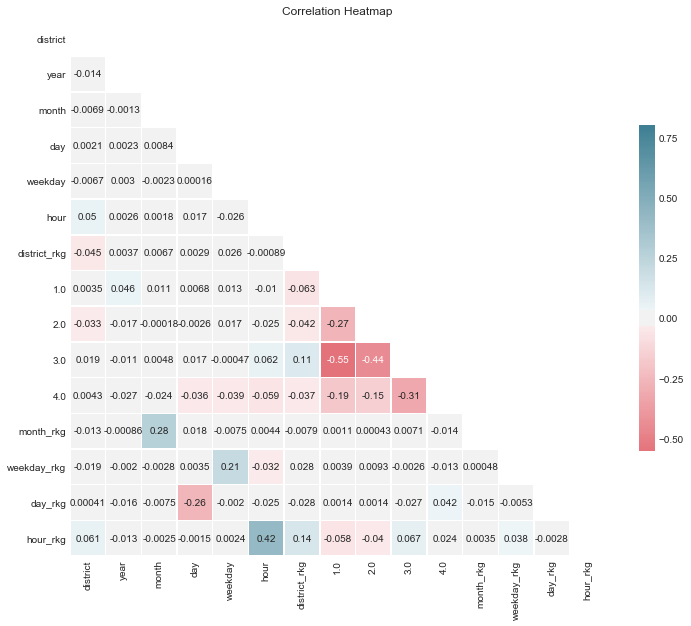

In [11]:
# Create a correlation heatmap
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix,
            mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.title('Correlation Heatmap')
plt.show()

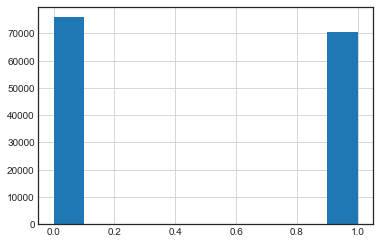

In [12]:
# Visualize the sparsity level (the ratio of 0 to 1 values) of the target variable:
df[3.0].hist()
plt.show()

In [13]:
df.shape

(146318, 15)

In [14]:
# Create test data set:
y = df[['district',3.0]]
X = df[['district','district_rkg','month_rkg', 'weekday_rkg', 'day_rkg','hour_rkg']]
districts = df.district.unique()

In [15]:
# Fit the logistic regression classifier for the first ten districts:

for i in districts[5:10]:

    # Create temp dataframes:
    X_temp = X[X.district==i]
    X_temp = X_temp.drop('district',axis=1)
    y_temp = y[y.district==i]
    y_temp = y_temp[3.0]
    
    # Call and fit the model:
    lr = LogisticRegression()
    fit = lr.fit(X_temp, y_temp)

    # Display_temp.
    print('\n---------\nDISTRICT:',i)
    print('\nCoefficients')
    print(fit.coef_)
    print(fit.intercept_)
    pred_y_temp_sklearn = lr.predict(X_temp)

    print('\n Accuracy_temp')
    print(pd.crosstab(pred_y_temp_sklearn, y_temp))

    print('\n Percentage accuracy_temp')
    print(lr.score(X_temp, y_temp))


---------
DISTRICT: 156

Coefficients
[[-0.25889597 -0.21075473  0.47112336 -0.09856404 -0.28955784]]
[-1.08093889]

 Accuracy_temp
3.0       0    1
row_0           
0      1899  625

 Percentage accuracy_temp
0.7523771790808241

---------
DISTRICT: 152

Coefficients
[[-0.01633704  0.11703222 -0.00880743 -0.19102478  2.32821779]]
[-0.06131145]

 Accuracy_temp
3.0       0     1
row_0            
0       121    98
1      1246  1343

 Percentage accuracy_temp
0.5213675213675214

---------
DISTRICT: 153

Coefficients
[[-0.09759152 -0.03108576  0.04425893 -0.10320649  0.53308002]]
[-0.42131752]

 Accuracy_temp
3.0       0    1
row_0           
0      1473  968

 Percentage accuracy_temp
0.6034412126177796

---------
DISTRICT: 1494

Coefficients
[[ 0.41535011 -0.09323211  0.20546997  0.09846094  0.30639103]]
[1.07808622]

 Accuracy_temp
3.0      0     1
row_0           
1      884  3176

 Percentage accuracy_temp
0.7822660098522167

---------
DISTRICT: 395

Coefficients
[[-0.08135778 -0.126

In [21]:
# Fit the logistic regression classifier for the first ten districts:

for i in districts[40:45]:

    # Create temp dataframes:
    X_temp = X[X.district==i]
    X_temp = X_temp.drop('district',axis=1)
    y_temp = y[y.district==i]
    y_temp = y_temp[3.0]
    
    # Call and fit the model:
    lr = LogisticRegression(penalty='l1')
    fit = lr.fit(X_temp, y_temp)

    # Display_temp.
    print('\n---------\nDISTRICT:',i)
    print('\nCoefficients')
    print(fit.coef_)
    print(fit.intercept_)
    pred_y_temp_sklearn = lr.predict(X_temp)

    print('\n Accuracy_temp')
    print(pd.crosstab(pred_y_temp_sklearn, y_temp))

    print('\n Percentage accuracy_temp')
    print(lr.score(X_temp, y_temp))


---------
DISTRICT: 1258

Coefficients
[[ 0.         0.         0.         0.        -1.6244777]]
[-0.62468987]

 Accuracy_temp
3.0       0    1
row_0           
0      1862  922

 Percentage accuracy_temp
0.6688218390804598

---------
DISTRICT: 1269

Coefficients
[[0. 0. 0. 0. 0.]]
[-0.40770224]

 Accuracy_temp
3.0       0     1
row_0            
0      1790  1189

 Percentage accuracy_temp
0.6008727760993622

---------
DISTRICT: 1243

Coefficients
[[0. 0. 0. 0. 0.]]
[-0.36718143]

 Accuracy_temp
3.0       0    1
row_0           
0      1436  993

 Percentage accuracy_temp
0.5911897900370523

---------
DISTRICT: 1273

Coefficients
[[0. 0. 0. 0. 0.]]
[-0.23385514]

 Accuracy_temp
3.0       0     1
row_0            
0      1315  1039

 Percentage accuracy_temp
0.5586236193712829

---------
DISTRICT: 1265

Coefficients
[[ 0.          0.          0.          0.         -0.79255519]]
[-0.37378616]

 Accuracy_temp
3.0       0     1
row_0            
0      1623  1074

 Percentage accuracy_

In [17]:
# Fit the logistic regression classifier for the first ten districts:

for i in districts[:5]:

    # Create temp dataframes:
    X_temp = X[X.district==i]
    X_temp = X_temp.drop('district',axis=1)
    y_temp = y[y.district==i]
    y_temp = y_temp[3.0]
    
    # Call and fit the model:
    lr = LogisticRegression(penalty='l2')
    fit = lr.fit(X_temp, y_temp)

    # Display_temp.
    print('\n---------\nDISTRICT:',i)
    print('\nCoefficients')
    print(fit.coef_)
    print(fit.intercept_)
    pred_y_temp_sklearn = lr.predict(X_temp)

    print('\n Accuracy_temp')
    print(pd.crosstab(pred_y_temp_sklearn, y_temp))

    print('\n Percentage accuracy_temp')
    print(lr.score(X_temp, y_temp))


---------
DISTRICT: 1241

Coefficients
[[-0.14506858 -0.06592804 -0.03199245 -0.17735423 -0.3607513 ]]
[-0.54115306]

 Accuracy_temp
3.0       0    1
row_0           
0      1833  992

 Percentage accuracy_temp
0.6488495575221239

---------
DISTRICT: 1823

Coefficients
[[-0.02634772 -0.43892829 -0.0075463  -0.14649522 -1.17825014]]
[-0.11416808]

 Accuracy_temp
3.0       0     1
row_0            
0      1349  1083

 Percentage accuracy_temp
0.5546875

---------
DISTRICT: 111

Coefficients
[[-0.00300874  0.06344117 -0.12551436 -0.22591273 -0.05231841]]
[-0.01119978]

 Accuracy_temp
3.0       0     1
row_0            
0      1440  1391

 Percentage accuracy_temp
0.5086541858000706

---------
DISTRICT: 1268

Coefficients
[[-0.14539257 -0.32233471 -0.01926418 -0.0802567  -0.39461888]]
[-0.56288449]

 Accuracy_temp
3.0       0    1
row_0           
0      1790  932

 Percentage accuracy_temp
0.6576047024246877

---------
DISTRICT: 162

Coefficients
[[ 0.08959379  0.22274618 -0.37463692 -0.